In [ ]:
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import numpy as np
import time
K = keras.backend
import pandas as pd
import math
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

tf.random.set_seed(42)
np.random.seed(42)
random_state=42

In [2]:
save_path = 'save_path'
os.chdir(save_path)

X_train_omics_unlabelled = pd.read_csv("X_train_omics_unlabelled.csv",index_col=0)
X_train_omics_labelled = pd.read_csv("X_train_omics_labelled.csv",index_col=0)
X_test_omics= pd.read_csv("X_test_omics.csv",index_col=0)
X_valid_omics= pd.read_csv("X_valid_omics.csv",index_col=0)
features = np.load("feature_selection.npy",allow_pickle=True)

train_set_labelled_y= pd.read_csv("train_set_labelled_y.csv",index_col=0)
test_set_labelled_y= pd.read_csv("test_set_labelled_y.csv",index_col=0)
valid_set_labelled_y= pd.read_csv("valid_set_labelled_y.csv",index_col=0)

X_train_omics_unlabelled = X_train_omics_unlabelled[features]
X_train_omics_labelled = X_train_omics_labelled[features]
X_test_omics = X_test_omics[features]
X_valid_omics = X_valid_omics[features]

train_set_labelled_c= pd.read_csv("train_set_labelled_c.csv",index_col=0)
train_set_unlabelled_c= pd.read_csv("train_set_unlabelled_c.csv",index_col=0)
test_set_labelled_c= pd.read_csv("test_set_labelled_c.csv",index_col=0)
valid_set_labelled_c= pd.read_csv("valid_set_labelled_c.csv",index_col=0)

#bin y 
from sklearn.preprocessing import KBinsDiscretizer
binner = KBinsDiscretizer(n_bins=10,encode="onehot-dense",strategy="uniform")
train_set_labelled_y = binner.fit_transform(train_set_labelled_y)
valid_set_labelled_y = binner.transform(valid_set_labelled_y)
test_set_labelled_y=binner.transform(test_set_labelled_y)

In [3]:
input_shape = X_train_omics_labelled.shape[1]

# Load best model (MMD) # 

## Custom parts ##

In [4]:
class Sampling(keras.layers.Layer):
    """reparameterization trick"""
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean   
    
    
class y_dist(keras.layers.Layer):
    """
    Custom layer that is used to learn the parameters, p, of the distribution over y.
    
    Outputs a loss and p. The loss is used for training. The loss is the categorical cross entropy loss between 
    p and every y sample. The mean of this is then taken to provide a per batch loss. 
    
    Shapes are configured for a 10D y. Change if you want to use different number of categories.
    
    """
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
    def build(self,batch_input_shape):
        self.q = self.add_weight(name="q",shape=[1,9],initializer="uniform",trainable=True)
        super().build(batch_input_shape)
    
    def call(self,X):
        concatenated = tf.concat([self.q,tf.constant(np.array(0.0).reshape(1,-1),dtype="float32")],axis=-1)
        p = K.exp(concatenated)
        p = tf.math.divide(p,K.sum(p))
        loss = keras.losses.categorical_crossentropy(X,p)
        loss = tf.reduce_mean(loss)
        return loss,p 
    
    def compute_output_shape(self,batch_input_shape):
        return tf.TensorShape(10)
    

## Load model ##

In [5]:
save_model_path = 'save_model_path'
os.chdir(save_model_path)

variational_encoder = keras.models.load_model("variational_encoder.h5", custom_objects={
   "Sampling": Sampling
})
variational_decoder = keras.models.load_model("variational_decoder.h5")
classifier = keras.models.load_model("classifier.h5")     
y_distribution = keras.models.load_model("y_distribution.h5", custom_objects={
   "y_dist": y_dist
})    

In [6]:
#for the loaded MMD model. Hyperparameters can be found in the relevant notebook.
codings_size=119

# Discriminator # 

In [ ]:
####### PREPARATION OF TRAINING DATA #######

#first column of label =1 if real data. Second column =1 if synthetic data. One hot encoding. 

#generate 383 synthetic data samples conditioned on y

########## Training data ###############

x_val_len = len(X_train_omics_labelled)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_sample = variational_decoder([z,train_set_labelled_y])
label_sample = np.hstack([np.zeros((383,1)),np.ones((383,1))])
label_real = np.hstack([np.ones((383,1)),np.zeros((383,1))])

#append the real and synthetic arrays

training_X = np.concatenate((X_train_omics_labelled.to_numpy(),x_sample))
training_y = np.concatenate((train_set_labelled_y,train_set_labelled_y))
training_label = np.concatenate((label_real,label_sample))


########## Validation data ###############

x_val_len = len(X_valid_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_sample = variational_decoder([z,valid_set_labelled_y])
label_sample = np.hstack([np.zeros((88,1)),np.ones((88,1))])
label_real = np.hstack([np.ones((88,1)),np.zeros((88,1))])

#append the real and synthetic arrays

valid_X = np.concatenate((X_valid_omics.to_numpy(),x_sample))
valid_y = np.concatenate((valid_set_labelled_y,valid_set_labelled_y))
valid_label = np.concatenate((label_real,label_sample))

In [ ]:
discriminator_x = keras.layers.Input(shape=[input_shape])
discriminator_y = keras.layers.Input(shape=[10])
discrimator_merged = keras.layers.concatenate([discriminator_x,discriminator_y])
d = keras.layers.Dense(10, activation="elu",kernel_initializer="he_normal")(discrimator_merged)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(2,activation="softmax")(d) 

discriminator = keras.models.Model(inputs=[discriminator_x,discriminator_y], outputs=[d])

In [ ]:
discriminator.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=0.00001))


In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [ ]:
discriminator.fit((training_X,training_y),training_label, epochs=400,validation_data=((valid_X,valid_y),valid_label),
               callbacks=[early_stopping_cb])

Below we see the results of the discriminator on a synthetic x sample (conditioned on test set y values). 

In [ ]:
test_len = len(X_test_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*test_len).reshape(test_len,codings_size)
x_new_sample = variational_decoder([z,test_set_labelled_y])
K.mean(discriminator([x_new_sample,test_set_labelled_y])[:,1])

Below we see the results of the discriminator on a real x sample for the above test set y values. 

In [ ]:
K.mean(discriminator([X_test_omics.to_numpy(),test_set_labelled_y])[:,1])

#### Training Discriminator on real vs random data ####

In [ ]:
####### PREPARATION OF TRAINING DATA #######

#first column of label =1 if real data. Second column =1 if synthetic data. One hot encoding. 

########## Training data ###############

x_val_len = len(X_train_omics_labelled)
x_sample = np.random.uniform(size=(x_val_len,290))
label_sample = np.hstack([np.zeros((383,1)),np.ones((383,1))])
label_real = np.hstack([np.ones((383,1)),np.zeros((383,1))])

#append the real and synthetic arrays

training_X = np.concatenate((X_train_omics_labelled.to_numpy(),x_sample))
training_y = np.concatenate((train_set_labelled_y,train_set_labelled_y))
training_label = np.concatenate((label_real,label_sample))


########## Validation data ###############

x_val_len = len(X_valid_omics)
x_sample = np.random.uniform(size=(x_val_len,290))
label_sample = np.hstack([np.zeros((88,1)),np.ones((88,1))])
label_real = np.hstack([np.ones((88,1)),np.zeros((88,1))])

#append the real and synthetic arrays

valid_X = np.concatenate((X_valid_omics.to_numpy(),x_sample))
valid_y = np.concatenate((valid_set_labelled_y,valid_set_labelled_y))
valid_label = np.concatenate((label_real,label_sample))

In [ ]:
discriminator_x = keras.layers.Input(shape=[input_shape])
discriminator_y = keras.layers.Input(shape=[10])
discrimator_merged = keras.layers.concatenate([discriminator_x,discriminator_y])
d = keras.layers.Dense(10, activation="elu",kernel_initializer="he_normal")(discrimator_merged)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(2,activation="softmax")(d) 

discriminator = keras.models.Model(inputs=[discriminator_x,discriminator_y], outputs=[d])

In [ ]:
discriminator.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=0.0001))


In [ ]:
discriminator.fit((training_X,training_y),training_label, epochs=400,validation_data=((valid_X,valid_y),valid_label),
               callbacks=[early_stopping_cb])

In [ ]:
K.mean(discriminator([X_test_omics.to_numpy(),test_set_labelled_y])[:,0])
#80% sure real data is real

In [ ]:
x_val_len = len(X_test_omics)
x_sample = np.random.uniform(size=(x_val_len,290))
K.mean(discriminator([x_sample,test_set_labelled_y])[:,1])
#98% sure random data is fake

In [296]:
tsne = TSNE(random_state=42)

In [304]:
omics_tsne = tsne.fit_transform(np.vstack([training_X,valid_X]))

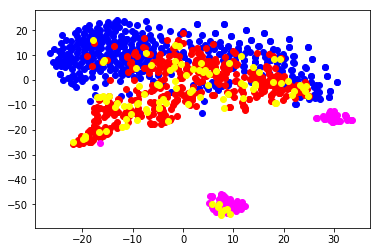

In [317]:
fig= plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=omics_tsne[0:383,0],y=omics_tsne[0:383,1],c="blue") #real
ax1.scatter(x=omics_tsne[383:766,0],y=omics_tsne[383:766,1],c="red") #fake
ax1.scatter(x=omics_tsne[766:846,0],y=omics_tsne[766:846,1],c="magenta") #real
ax1.scatter(x=omics_tsne[846:,0],y=omics_tsne[846:,1],c="yellow") #fake



plt.show()

#shows that real and fake data are well mixed

# Random Forest # 

### Real vs random data ###

In [153]:
####### PREPARATION OF TRAINING DATA #######

#first column of label =1 if real data. 

########## Training data ###############

x_val_len = len(X_train_omics_labelled)
x_sample = np.random.uniform(size=(x_val_len,290))
label_sample = np.hstack([np.zeros((383,1)),np.ones((383,1))])
label_real = np.hstack([np.ones((383,1)),np.zeros((383,1))])

#append the real and synthetic arrays

training_X = np.concatenate((X_train_omics_labelled.to_numpy(),x_sample))
training_y = np.concatenate((train_set_labelled_y,train_set_labelled_y))
training_label = np.concatenate((label_real,label_sample))[:,0]
train_x = np.hstack([training_X,training_y])


########## Validation data ###############

x_val_len = len(X_valid_omics)
x_sample = np.random.uniform(size=(x_val_len,290))
label_sample = np.hstack([np.zeros((88,1)),np.ones((88,1))])
label_real = np.hstack([np.ones((88,1)),np.zeros((88,1))])

#append the real and synthetic arrays

valid_X = np.concatenate((X_valid_omics.to_numpy(),x_sample))
valid_y = np.concatenate((valid_set_labelled_y,valid_set_labelled_y))
valid_label = np.concatenate((label_real,label_sample))[:,0]
valid_x = np.hstack([valid_X,valid_y])

########### Test data ##############

x_val_len = len(X_test_omics)
test_x_random = np.random.uniform(size=(x_val_len,290)) 
test_X = np.concatenate((X_test_omics.to_numpy(),test_x_random))
test_y = np.concatenate((test_set_labelled_y,test_set_labelled_y))
test_x = np.hstack([test_X,test_y])

In [166]:
rfc = RandomForestClassifier(n_estimators=200,max_depth=1,n_jobs=2,random_state=random_state)

In [167]:
rfc.fit(train_x,training_label)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [168]:
rfc.score(valid_x,valid_label) #for hyperparameter tuning

0.6193181818181818

In [169]:
np.mean((rfc.predict_proba(train_x))[:383,1])
#prob real train set is real

0.7669228001542858

In [170]:
np.mean((rfc.predict_proba(train_x))[383:,1])
#prob random is real

0.2317326119590557

In [171]:
np.mean((rfc.predict_proba(valid_x))[:88,1])
#prob real valid is real

0.397602851029086

In [172]:
np.mean((rfc.predict_proba(valid_x))[88:,1])
#prob random valid is real

0.2255596118297712

In [173]:
np.mean((rfc.predict_proba(test_x))[:106,1])
#prob real test set is real

0.39284192781908733

In [174]:
np.mean((rfc.predict_proba(test_x))[106:,1])
#prob random test set is real

0.2265592107451185

### Real vs Synthetic data ###

In [175]:
####### PREPARATION OF TRAINING DATA #######

#first column of label =1 if real data. 

########## Training data ###############

x_val_len = len(X_train_omics_labelled)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_sample = variational_decoder([z,train_set_labelled_y])
label_sample = np.hstack([np.zeros((383,1)),np.ones((383,1))])
label_real = np.hstack([np.ones((383,1)),np.zeros((383,1))])

#append the real and synthetic arrays

training_X = np.concatenate((X_train_omics_labelled.to_numpy(),x_sample))
training_y = np.concatenate((train_set_labelled_y,train_set_labelled_y))
training_label = np.concatenate((label_real,label_sample))[:,0]


########## Validation data ###############

x_val_len = len(X_valid_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_sample = variational_decoder([z,valid_set_labelled_y])
label_sample = np.hstack([np.zeros((88,1)),np.ones((88,1))])
label_real = np.hstack([np.ones((88,1)),np.zeros((88,1))])

#append the real and synthetic arrays

valid_X = np.concatenate((X_valid_omics.to_numpy(),x_sample))
valid_y = np.concatenate((valid_set_labelled_y,valid_set_labelled_y))
valid_label = np.concatenate((label_real,label_sample))[:,0]

############ Test data ###########

test_len = len(X_test_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*test_len).reshape(test_len,codings_size)
test_x_synthetic = variational_decoder([z,test_set_labelled_y])
test_X = np.concatenate((X_test_omics.to_numpy(),test_x_synthetic))
test_y = np.concatenate((test_set_labelled_y,test_set_labelled_y))
test_x = np.hstack([test_X,test_y])



look at the decision tree graphic

In [194]:

rfc = RandomForestClassifier(n_estimators=220,max_depth=1,n_jobs=2,random_state=42)

In [195]:
rfc.fit(train_x,training_label)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=220, n_jobs=2,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [196]:
rfc.score(valid_x,valid_label)

0.6193181818181818

In [182]:
np.mean((rfc.predict_proba(train_x))[:383,1])
#prob real train set is real

0.7701209953981267

In [183]:
np.mean((rfc.predict_proba(train_x))[383:,1])
#prob synthetic train set is real

0.22891754690022448

In [184]:
np.mean((rfc.predict_proba(valid_x))[:88,1])
#prob real val set is real

0.38444520302090784

In [185]:
np.mean((rfc.predict_proba(valid_x))[88:,1])

#avg prob that the synthetic valid set is real

0.22136396539737538

In [186]:
np.mean((rfc.predict_proba(test_x))[:106,1])
#prob real test set is real

0.3803456714712181

In [187]:
np.mean((rfc.predict_proba(test_x))[106:,1])
#prob synthetic test set is real

0.6141514592176345

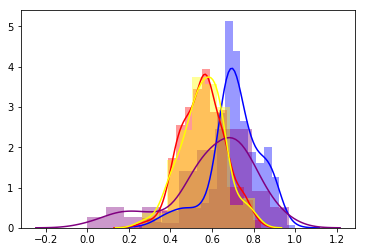

In [380]:
import seaborn 
seaborn.distplot(training_X[:383,271],color="blue") #real
seaborn.distplot(training_X[383:,271],color="red") #synthetic
seaborn.distplot(valid_X[:88,271],color="purple") #real
seaborn.distplot(valid_X[88:,271],color="yellow") #synthetic

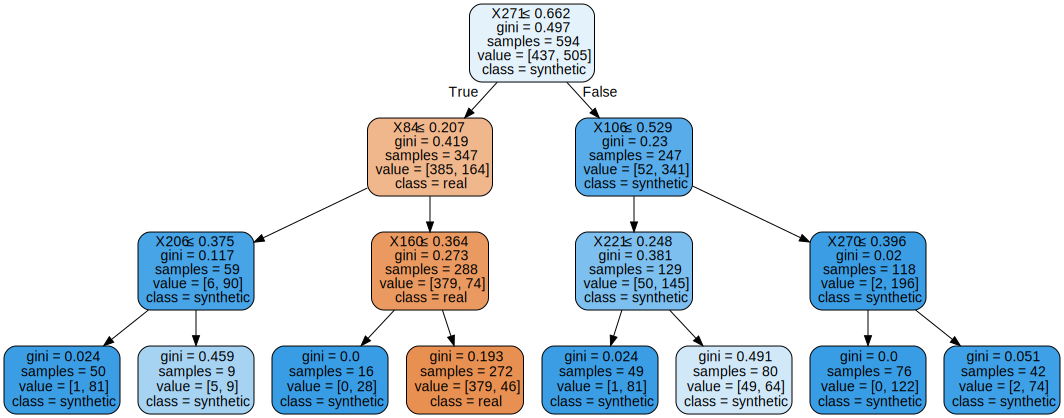

In [346]:
import graphviz
dot_data = export_graphviz(dtree, out_file=None ,
                                
         
                     filled=True, rounded=True,  
                      special_characters=True,
                          class_names=["real","synthetic"])
graph = graphviz.Source(dot_data) 
graph

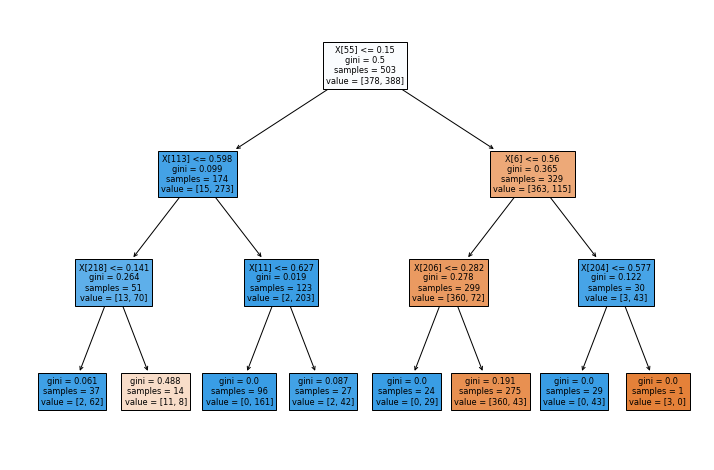

In [249]:
plt.figure(figsize=(12,8))
plot_tree(tree,filled=True)
plt.show()